In [81]:
import numpy as np
import pandas as pd
from scipy.stats import norm,kstest,shapiro,t
from scipy.optimize import fsolve
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import *
import statistics
from tabulate import tabulate
import statsmodels.api as sm
import scipy.optimize as sco

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Basic Functions

In [83]:
def black_scholes(S,K,T,r,q,sigma,option_dir):
  d1 = (np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
  d2 = d1-sigma*np.sqrt(T)
  if option_dir == "Call":
    return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
  else:
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)

In [84]:
def implied_volatility(S,K,T,r,q,opt_price,option_dir):
  volatility = lambda x: black_scholes(S,K,T,r,q,x,option_dir) - opt_price
  return fsolve(volatility, x0 = 0.5)[0]

In [85]:
def BS_Greeks(S,K,T,r,q,sigma,option_dir):
  d1 = (np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
  d2 = d1-sigma*np.sqrt(T)
  def delta():
    factor = np.exp((-q * T))
    if option_dir == "Call":
      return factor * norm.cdf(d1)
    else:
      return factor * (norm.cdf(d1) - 1)

  def gamma():
    return np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))

  def vega():
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T) / 100

  def theta():
    if option_dir == "Call":
      opt = 1
    else:
      opt = -1
    df = np.exp(-r * T)
    dfq = np.exp(-q * T)
    tmptheta = -0.5 * S * dfq * norm.pdf(d1) * sigma / np.sqrt(T) + opt * q * S * dfq * norm.cdf(d1) - opt * r * K * df * norm.cdf(opt * d2)
    return tmptheta / 365

  def rho():
    if option_dir == "Call":
      sign = 1 
    else: 
      sign = -1
    df = np.exp(-r * T)
    return sign * T * K * df * norm.cdf(sign * d2) / 100

  def phi():
    if option_dir == "Call":
      sign = 1 
    else: 
      sign = -1
    dfq = np.exp(-q * T)
    return -sign * T * S * dfq * norm.cdf(sign * d1) / 100
  
  greek_frame = pd.DataFrame(np.array([delta(), gamma(), vega(), theta(), rho(), phi()]),
                  index=['delta', 'gamma', 'vega', 'theta', 'rho', 'phi'], columns=['GBSM'])
  return greek_frame


In [86]:
def FD_Greeks(S,K,T,r,q,sigma,option_dir,difference):
  dif_1 = difference
  dif_2 = difference/10
  def delta(ds = dif_1):
    u = black_scholes(S + ds, K, T, r, q, sigma, option_dir)
    d = black_scholes(S - ds, K, T, r, q, sigma, option_dir)
    return 0.5 * (u - d) / ds

  def gamma(ds = dif_1):
    u = black_scholes(S + ds, K, T, r, q, sigma, option_dir)
    m = black_scholes(S, K, T, r, q, sigma, option_dir)
    d = black_scholes(S - ds, K, T, r, q, sigma, option_dir)
    return (u - 2 * m + d) / ds / ds

  def vega(dsig = dif_2):
    u = black_scholes(S, K, T, r, q, sigma + dsig, option_dir)
    d = black_scholes(S, K, T, r, q, sigma - dsig, option_dir)
    return 0.5 * (u - d) / dsig / 100

  def theta(dt = dif_2):
    u = black_scholes(S, K, T - dt, r, q, sigma, option_dir)
    d = black_scholes(S, K, T + dt, r, q, sigma, option_dir)
    return 0.5 * (u - d) / dt / 365

  def rho(dr = dif_2):
    u = black_scholes(S, K, T, r + dr, q, sigma, option_dir)
    d = black_scholes(S, K, T, r - dr, q, sigma, option_dir)
    return 0.5 * (u - d) / dr / 100

  def phi(db = dif_2):
    u = black_scholes(S, K, T, r, q + db, sigma, option_dir)
    d = black_scholes(S, K, T, r, q - db, sigma, option_dir)
    return 0.5 * (u - d) / db / 100
  
  greek_frame = pd.DataFrame(np.array([delta(), gamma(), vega(), theta(), rho(), phi()]),
                  index=['delta', 'gamma', 'vega', 'theta', 'rho', 'phi'], columns=['FDM'])
  return greek_frame

In [87]:
def binary_tree(underlying,strike,ttm,rf,b,ivol,N,option_dir):
  dt = ttm/N
  u = np.exp(ivol*np.sqrt(dt))
  d = 1/u
  pu = (np.exp(b*dt)-d)/(u-d)
  pd = 1.0-pu
  df = np.exp(-rf*dt)
  if option_dir == "Call": 
    z = 1
  else:
    z = -1
  
  def nodes_fuc(n):
    nodes_count = (n+1)*(n+2)/2
    return int(nodes_count)

  def index_fuc(i,j):
    nodes_count = nodes_fuc(j-1)
    index = nodes_count + i - 1
    return index
  
  total_nodes = nodes_fuc(N)
  option_values = np.zeros(total_nodes)

  for j in range(N,-1,-1):
    for i in range(j,-1,-1):
      idx = index_fuc(i,j)
      price = underlying*u**i*d**(j-i)        
      if j < (N-1):
        option_values[idx] = max(option_values[idx], df*(pu*option_values[index_fuc(i+1,j+1)] + pd*option_values[index_fuc(i,j+1)]))
      else:
        option_values[idx] = max(0, z*(price-strike)) 
  return option_values[0]

In [88]:
def american_binary_tree(underlying,strike,ttm,rf,ivol,N,option_dir,div_amount,div_time):
  dt = ttm/N
  u = np.exp(ivol*np.sqrt(dt))
  d = 1/u
  pu = (np.exp(rf*dt)-d)/(u-d)
  pd = 1.0-pu
  df = np.exp(-rf*dt)
  if option_dir == "Call": 
    z = 1
  else:
    z = -1

  if not div_amount or not div_time or div_time[0] > N:
    return binary_tree(underlying,strike,ttm,rf,0,ivol,N,option_dir)
  
  def nodes_fuc(n):
    nodes_count = (n+1)*(n+2)/2
    return int(nodes_count)

  def index_fuc(i,j):
    nodes_count = nodes_fuc(j-1)
    index = nodes_count + i - 1
    return index
  
  total_nodes = nodes_fuc(div_time[0])
  option_values = np.zeros(total_nodes)

  for j in range(div_time[0],-1,-1):
    for i in range(j,-1,-1):
      idx = index_fuc(i,j)
      price = underlying*u**i*d**(j-i)        
      if j < (div_time[0]-1):
        option_values[idx] = max(0, z*(price-strike)) 
        option_values[idx] = max(option_values[idx], df*(pu*option_values[index_fuc(i+1,j+1)] + pd*option_values[index_fuc(i,j+1)]))
      else:
        valNoExercise = american_binary_tree(price-div_amount[0], strike, ttm-div_time[0]*dt, rf, ivol, N-div_time[0], option_dir, div_amount[1:], div_time[1:])
        valExercise =  max(0,z*(price-strike))
        option_values[idx] = max(valNoExercise,valExercise)
  return option_values[0]

In [89]:
def American_BT_Greeks(underlying,strike,ttm,rf,ivol,N,option_dir,difference,div_amount,div_time):
  dif_1 = difference
  dif_2 = difference/10
  def delta(ds = dif_1):
    u = american_binary_tree(underlying + ds,strike,ttm,rf,ivol,N,option_dir,div_amount,div_time)
    d = american_binary_tree(underlying - ds,strike,ttm,rf,ivol,N,option_dir,div_amount,div_time)
    return 0.5 * (u - d) / ds

  def gamma(ds = dif_1):
    u = american_binary_tree(underlying + ds,strike,ttm,rf,ivol,N,option_dir,div_amount,div_time)
    m = american_binary_tree(underlying,strike,ttm,rf,ivol,N,option_dir,div_amount,div_time)
    d = american_binary_tree(underlying - ds,strike,ttm,rf,ivol,N,option_dir,div_amount,div_time)
    return (u - 2 * m + d) / ds / ds

  def vega(dsig = dif_2):
    u = american_binary_tree(underlying,strike,ttm,rf,ivol + dsig,N,option_dir,div_amount,div_time)
    d = american_binary_tree(underlying,strike,ttm,rf,ivol - dsig,N,option_dir,div_amount,div_time)
    return 0.5 * (u - d) / dsig / 100

  def theta(dt = dif_2):
    u = american_binary_tree(underlying,strike,ttm + dt,rf,ivol,N,option_dir,div_amount,div_time)
    d = american_binary_tree(underlying,strike,ttm - dt,rf,ivol,N,option_dir,div_amount,div_time)
    return 0.5 * (u - d) / dt / 365

  def rho(dr = dif_2):
    u = american_binary_tree(underlying,strike,ttm,rf + dr,ivol,N,option_dir,div_amount,div_time)
    d = american_binary_tree(underlying,strike,ttm,rf - dr,ivol,N,option_dir,div_amount,div_time)
    return 0.5 * (u - d) / dr / 100

  def phi(db = dif_2):
    phi = "No phi"
    return phi
  
  greek_frame = pd.DataFrame(np.array([delta(), gamma(), vega(), theta(), rho(), phi()]),
                  index=['delta', 'gamma', 'vega', 'theta', 'rho', 'phi'], columns=[option_dir])
  return greek_frame

In [90]:
def BT_Greeks(underlying,strike,ttm,rf,b,ivol,N,option_dir,difference):
  dif_1 = difference
  dif_2 = difference/10
  def delta(ds = dif_1):
    u = binary_tree(underlying + ds,strike,ttm,rf,b,ivol,N,option_dir)
    d = binary_tree(underlying - ds,strike,ttm,rf,b,ivol,N,option_dir)
    return 0.5 * (u - d) / ds

  def gamma(ds = dif_1):
    u = binary_tree(underlying + ds,strike,ttm,rf,b,ivol,N,option_dir)
    m = binary_tree(underlying,strike,ttm,rf,b,ivol,N,option_dir)
    d = binary_tree(underlying - ds,strike,ttm,rf,b,ivol,N,option_dir)
    return (u - 2 * m + d) / ds / ds

  def vega(dsig = dif_2):
    u = binary_tree(underlying,strike,ttm,rf,b,ivol + dsig,N,option_dir)
    d = binary_tree(underlying,strike,ttm,rf,b,ivol - dsig,N,option_dir)
    return 0.5 * (u - d) / dsig / 100

  def theta(dt = dif_2):
    u = binary_tree(underlying,strike,ttm + dt,rf,b,ivol,N,option_dir)
    d = binary_tree(underlying,strike,ttm - dt,rf,b,ivol,N,option_dir)
    return 0.5 * (u - d) / dt / 365

  def rho(dr = dif_2):
    u = binary_tree(underlying,strike,ttm,rf + dr,b,ivol,N,option_dir)
    d = binary_tree(underlying,strike,ttm,rf - dr,b,ivol,N,option_dir)
    return 0.5 * (u - d) / dr / 100

  def phi(db = dif_2):
    u = binary_tree(underlying,strike,ttm,rf,b + db,ivol,N,option_dir)
    d = binary_tree(underlying,strike,ttm,rf,b - db,ivol,N,option_dir)
    return 0.5 * (u - d) / db / 100
  
  greek_frame = pd.DataFrame(np.array([delta(), gamma(), vega(), theta(), rho(), phi()]),
                  index=['delta', 'gamma', 'vega', 'theta', 'rho', 'phi'], columns=[option_dir])
  return greek_frame

In [91]:
def effFrontier(mu, cov, scope, rf, shortsell):
    def portfolio_stats(weights):
      weights = np.array(weights)[:, np.newaxis]
      port_rets = weights.T @ mu
      port_vols = np.sqrt(weights.T @ cov @ weights)

      return np.array([port_rets, port_vols, (port_rets - rf) / port_vols]).flatten()

    # Maximizing sharpe ratio/ method to find tangency portfolio
    def min_sharpe_ratio(weights):
      return -portfolio_stats(weights)[2]

    # Minimize the volatility
    def min_volatility(weights):
      return portfolio_stats(weights)[1]

    numOfAssets = len(mu)
    cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})
    stocks = mu.index
    mu = np.array(mu)
    cov = np.array(cov)
    # print(mu)
    initial_wts = np.array(numOfAssets * [1. / numOfAssets])

    # find efficient frontier
    targetrets = np.linspace(scope[0], scope[1], scope[2])
    tvols = []

    for tr in targetrets:

        # for short sale forbid constraints
        bnds = tuple((0, 1) for x in range(numOfAssets))
        ef_cons = ({'type': 'eq', 'fun': lambda x: portfolio_stats(x)[0] - tr},
                   {'type': 'eq', 'fun': lambda x: sum(x) - 1})

        if shortsell == True:
            opt_ef = sco.minimize(min_volatility, initial_wts, method='SLSQP', constraints=ef_cons)
        else:
            opt_ef = sco.minimize(min_volatility, initial_wts, method='SLSQP', bounds=bnds, constraints=ef_cons)

        tvols.append(opt_ef['fun'])
    targetvols = np.array(tvols)
    # Dataframe for EF
    efPort = pd.DataFrame({
        'targetrets': np.around(targetrets, 4),
        'targetvols': np.around(targetvols, 4),
        'targetsharpe': np.around((targetrets - rf) / targetvols, 4)
    })
    bnds = tuple((0, 1) for x in range(numOfAssets))
    # Tangency Portfolio
    if shortsell == True:
        opt_sharpe = sco.minimize(min_sharpe_ratio, initial_wts, method='SLSQP', constraints=cons)
    else:
        opt_sharpe = sco.minimize(min_sharpe_ratio, initial_wts, method='SLSQP', bounds=bnds, constraints=cons)

    w = opt_sharpe.x
    stat = portfolio_stats(w)
    Tangencyrets, Tangencyvols, Tangencysharpe = stat[0], stat[1], stat[2]
    tangencyPort = pd.Series([Tangencyrets, Tangencyvols, Tangencysharpe], index=['ret', 'vol', 'sharpe'])
    assetWeight = pd.DataFrame(w, index=stocks, columns=['Weight'])
    return efPort, tangencyPort, assetWeight

In [92]:
def simulate_history(df, alpha):
  VaR = -np.percentile(df,alpha)
  print(f"Historic Simulation VaR: {round(VaR*100,2)}%")
  return VaR

In [93]:
def ES(ret_arr, alpha):
  VaR_t = -np.percentile(ret_arr, alpha)
  return_before_alpha = ret_arr[ret_arr < -VaR_t]
  ES = return_before_alpha.mean()
  print(f"Expected Shortfall: {round(-ES*100,2)}%")
  return -ES

#Problem 1

In [94]:
current = datetime(2022,3,13)
expiration = datetime(2022,4,15)
TTM = (expiration-current).days

S = 165
K = 165
T = TTM/365
r = 0.25/100
q = 0.53/100
sigma = 0.2

In [95]:
bscall = BS_Greeks(S, K, T, r, q, sigma, "Call")
bsput = BS_Greeks(S, K, T, r, q, sigma, "Call")
fdcall = FD_Greeks(S, K, T, r, q, sigma, "Call", 0.01)
fdput = FD_Greeks(S, K, T, r, q, sigma, "Call", 0.01)


allgreek = pd.concat([bscall,bsput,fdcall,fdput],axis=1)
allgreek

,GBSM,GBSM,FDM,FDM
delta,0.510071,0.510071,0.510071,0.510071
gamma,0.040173,0.040173,0.040173,0.040173
vega,0.197766,0.197766,0.197766,0.197766
theta,-0.059256,-0.059256,-0.059257,-0.059257
rho,0.072533,0.072533,0.072533,0.072533
phi,-0.076091,-0.076091,-0.076091,-0.076091


In [96]:
bs_price = black_scholes(S, K, T, r, q, sigma, "Call")
bs_price

3.935701257793056

In [97]:
N = 200
DivTime = (datetime(2022,4,11)-datetime(2022,3,13)).days/365
div_time = [int((DivTime/TTM)*N)]
#div_time = [DivTime]
div_amount = [0.88]
div_Call = american_binary_tree(165,165,T,r,sigma,N,"Call",div_amount,div_time)
div_Put = american_binary_tree(165,165,T,r,sigma,N,"Put",div_amount,div_time)
table = [[div_Call, div_Put]]
header = ['American Call','American Put']
print(tabulate(table,headers=header))

  American Call    American Put
---------------  --------------
        3.18013         4.75618


In [98]:
BTcall = American_BT_Greeks(165,165,T,r,sigma,N,"Call",0.01,div_amount,div_time)
BTput = American_BT_Greeks(165,165,T,r,sigma,N,"Put",0.01,div_amount,div_time)
allgreek = pd.concat([BTcall,BTput],axis=1)
allgreek

,Call,Put
delta,0.4254278837831471,-0.5701060357740761
gamma,3.552713678800501e-11,2.6645352591003757e-11
vega,0.17685542410467156,0.211594087936966
theta,0.053571813065296875,0.06408815568438354
rho,-0.002846432852467995,-0.004257110634595662
phi,No phi,No phi


#Problem2

In [99]:
S = 164.85
r = 0.25/100
DivTime = (datetime(2022,3,15)-datetime(2022,2,25)).days/365
port = pd.read_csv('/content/drive/MyDrive/risk data/problem2.csv')
port

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,3/18/2022,165.0,4.50
1,Straddle,Option,AAPL,1,Put,3/18/2022,165.0,4.40
2,SynLong,Option,AAPL,1,Call,3/18/2022,165.0,4.50
3,SynLong,Option,AAPL,-1,Put,3/18/2022,165.0,4.40
4,CallSpread,Option,AAPL,1,Call,3/18/2022,165.0,4.50
5,CallSpread,Option,AAPL,-1,Call,3/18/2022,175.0,0.72
6,PutSpread,Option,AAPL,1,Put,3/18/2022,165.0,4.40
7,PutSpread,Option,AAPL,-1,Put,3/18/2022,155.0,1.60
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,164.85
9,Call,Option,AAPL,1,Call,3/18/2022,165.0,4.50


In [100]:
returns_set = pd.read_csv('/content/drive/MyDrive/risk data/DailyReturn.csv',index_col = 0)
returns = returns_set['AAPL']
aaplSigma = returns.std()

In [101]:
div_time = [int((DivTime/TTM)*N)]
K = port['Strike']
Dir = port['OptionType']
opt_price = port['CurrentPrice']
implied_vol = []
optDelta = []
for i in range(len(K)):
  if port['Type'][i]=='Option':
    implied_vol.append(implied_volatility(S,K[i],T,r,q,opt_price[i],Dir[i]))   
  else:
    implied_vol.append(np.nan)
for i in range(len(K)):
  if port['Type'][i]=='Option':
    optDelta.append(American_BT_Greeks(S,K[i],T,r,implied_vol[i],N,Dir[i],0.01,[1],div_time).iloc[0,0])
  else:
    optDelta.append(1)

In [102]:
port['Implied vol'] = np.array(implied_vol)
port['Delta'] = np.array(optDelta)
port

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice,Implied vol,Delta
0,Straddle,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.232402,0.4270297606522311
1,Straddle,Option,AAPL,1,Put,3/18/2022,165.0,4.40,0.217642,-0.5688603871564446
2,SynLong,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.232402,0.4270297606522311
3,SynLong,Option,AAPL,-1,Put,3/18/2022,165.0,4.40,0.217642,-0.5688603871564446
4,CallSpread,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.232402,0.4270297606522311
5,CallSpread,Option,AAPL,-1,Call,3/18/2022,175.0,0.72,0.188846,0.118476653784233
6,PutSpread,Option,AAPL,1,Put,3/18/2022,165.0,4.40,0.217642,-0.5688603871564446
7,PutSpread,Option,AAPL,-1,Put,3/18/2022,155.0,1.60,0.264137,-0.24712270990578933
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,164.85,NaN,1
9,Call,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.232402,0.4270297606522311


In [103]:
Strategy = port['Portfolio'].unique()
portGrad = []
Port_pv = []
for i in range(len(Strategy)):
  data = port[port['Portfolio']==Strategy[i]] 
  pv = (data['CurrentPrice']*data['Holding']).sum()
  Port_pv.append(pv)
  grad = S/pv * (data['Holding']*(data['Delta'].astype(float))).sum()
  portGrad.append(grad)

portSigma = []
for grad in portGrad:
  portSigma.append(np.abs(grad)*aaplSigma)

In [105]:
rets_sim = pd.DataFrame()
for i in range(len(portSigma)):
  return_simu = norm.rvs(size = 10000, loc=0, scale = portSigma[i]*np.sqrt(10))
  rets_sim[Strategy[i]] = return_simu
    

pred_mean = []
pred_VaR = []
pred_es = []
for i in range(len(Strategy)):
  sim_PnL = Port_pv[i]*(rets_sim[Strategy[i]])
  pred_mean.append(sim_PnL.mean())
  pred_VaR.append(simulate_history(sim_PnL,5))
  pred_es.append(ES(sim_PnL,5))

Historic Simulation VaR: 195.63%
Expected Shortfall: 246.16%
Historic Simulation VaR: 1350.18%
Expected Shortfall: 1702.77%
Historic Simulation VaR: 419.46%
Expected Shortfall: 521.45%
Historic Simulation VaR: 440.88%
Expected Shortfall: 555.21%
Historic Simulation VaR: 1404.02%
Expected Shortfall: 1726.34%
Historic Simulation VaR: 579.84%
Expected Shortfall: 718.23%
Historic Simulation VaR: 762.51%
Expected Shortfall: 966.68%
Historic Simulation VaR: 798.54%
Expected Shortfall: 1003.11%
Historic Simulation VaR: 596.24%
Expected Shortfall: 744.4%


In [106]:
stat = pd.DataFrame({"Mean":pred_mean,'VaR':pred_VaR,'ES':pred_es},index = Strategy)
stat

,Mean,VaR,ES
Straddle,-0.008531,1.956320,2.461632
SynLong,0.007863,13.501817,17.027653
CallSpread,-0.017573,4.194568,5.214515
PutSpread,0.004957,4.408845,5.552085
Stock,-0.045021,14.040167,17.263396
Call,0.030325,5.798407,7.182334
Put,-0.001679,7.625133,9.666796
CoveredCall,-0.018850,7.985433,10.031100
ProtectedPut,-0.019480,5.962380,7.444021


#Problem 3

In [107]:
ff_4th = pd.read_csv('/content/drive/MyDrive/risk data/F-F_Momentum_Factor_daily.CSV', parse_dates=['Date']).set_index('Date')/100
ff_4th.rename(columns = {'Mom   ':"Mom"},inplace=True)

In [108]:
returns = pd.read_csv('/content/drive/MyDrive/risk data/DailyReturn.csv', parse_dates=['Date']).set_index('Date')
returns.index = pd.DatetimeIndex(returns.index)

In [109]:
FF = pd.read_csv('/content/drive/MyDrive/risk data/F-F_Research_Data_Factors_daily.CSV')
FF['Date'] = FF['Date'].apply(lambda x: str(datetime.strptime(str(x), '%Y%m%d').date()))
FF.set_index('Date',inplace=True)
FF.index = pd.DatetimeIndex(FF.index)
FF /=100
FF = FF.join(ff_4th)
RF = returns.join(FF)

In [111]:
stock_list = ['AAPL','FB','UNH','MA','MSFT','NVDA','HD','PFE','AMZN','BRK-B','PG','XOM','TSLA','JPM','V','DIS','GOOGL','JNJ','BAC','CSCO']
factor_list = ['Mkt-RF','SMB','HML','Mom']
param_dict = {}

x1 = RF['Mkt-RF']
x2 = RF['SMB']
x3 = RF['HML']
x4 = RF['Mom']

X = pd.DataFrame({"Mkt-RF":x1, "SMB":x2,"HML":x3,'Mom':x4})
X_ = sm.add_constant(X)
for stock in stock_list:
    Y = returns[stock] - RF['RF']
    result = sm.OLS(Y, X_).fit()
    param_dict[stock] = (result.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [112]:
FF_10years = FF[FF.index>=datetime(2012,1,31)]
exp_rets_frame = pd.DataFrame()
for stock, param in param_dict.items():
  exp_rets = FF_10years[factor_list]@param[factor_list]+FF_10years['RF'].mean()
  exp_rets_frame[stock] = exp_rets
stock_means = np.log(1 + exp_rets_frame.mean()) * 255
covariance = np.log(1 + returns[stock_list]).cov() * 255
stock_means

AAPL     0.143414
FB       0.219205
UNH      0.137663
MA       0.261014
MSFT     0.172935
NVDA     0.325676
HD       0.100648
PFE     -0.150353
AMZN     0.186311
BRK-B    0.112803
PG       0.077017
XOM      0.179250
TSLA     0.184864
JPM      0.132777
V        0.190974
DIS      0.150065
GOOGL    0.194495
JNJ      0.075037
BAC      0.172139
CSCO     0.137953
dtype: float64

In [113]:
covariance

,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.065441,0.031073,0.020744,0.010865,0.039993,0.081306,0.020419,-0.021341,0.041714,0.000136,-0.002699,0.008210,0.081903,0.005251,0.010712,0.012826,0.031423,-0.003238,0.005305,0.011880
FB,0.031073,0.104613,0.008503,0.040435,0.037940,0.071235,0.007342,-0.034076,0.039219,0.009335,0.000548,0.016634,0.070407,0.003429,0.034626,0.029683,0.036417,0.005036,0.008607,0.016598
UNH,0.020744,0.008503,0.044678,0.025495,0.022884,0.037212,0.016155,-0.006501,0.018861,0.002269,0.011324,0.009566,0.024662,0.003660,0.018395,0.010282,0.021946,0.008787,0.003671,0.015559
MA,0.010865,0.040435,0.025495,0.129913,0.008331,0.032840,0.013766,-0.025942,0.018757,0.020274,0.012592,0.047964,0.042987,0.027444,0.098294,0.044054,0.010899,0.013416,0.040533,0.017995
MSFT,0.039993,0.037940,0.022884,0.008331,0.065237,0.089283,0.022864,-0.018821,0.033346,-0.001568,0.002797,0.004023,0.078434,-0.003993,0.003577,0.010030,0.051307,-0.001555,-0.000343,0.022863
NVDA,0.081306,0.071235,0.037212,0.032840,0.089283,0.354876,0.052871,-0.048652,0.100484,-0.003756,-0.009097,0.033804,0.188497,0.007134,0.041099,0.023697,0.083843,-0.013139,0.017036,0.013277
HD,0.020419,0.007342,0.016155,0.013766,0.022864,0.052871,0.058241,-0.022702,0.014528,0.000238,0.006162,0.005143,0.028978,0.014535,0.013316,0.011541,0.022639,0.002178,0.007904,0.003715
PFE,-0.021341,-0.034076,-0.006501,-0.025942,-0.018821,-0.048652,-0.022702,0.177019,-0.027410,-0.012057,0.005692,-0.036887,-0.055088,-0.022267,-0.015947,-0.023313,-0.021314,0.006779,-0.034283,-0.002152
AMZN,0.041714,0.039219,0.018861,0.018757,0.033346,0.100484,0.014528,-0.027410,0.066280,-0.001549,-0.003372,0.013645,0.041839,-0.001034,0.010257,0.017323,0.039699,-0.003340,0.002833,0.002798
BRK-B,0.000136,0.009335,0.002269,0.020274,-0.001568,-0.003756,0.000238,-0.012057,-0.001549,0.022978,0.009790,0.023074,-0.005053,0.022736,0.018162,0.010155,0.001378,0.009128,0.028815,0.007915


In [114]:
efport, tangency, assetWeight = effFrontier(stock_means, covariance, (0.01,0.3,100), 0.0025, True)
tangency

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


ret       0.146135
vol       0.119725
sharpe    1.199701
dtype: float64

In [26]:
efport_noshort, tangency_noshort, assetWeight_noshort = effFrontier(stock_means, covariance, (0.01,0.3,100), 0.0025, False)
tangency_noshort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


ret       0.144614
vol       0.118647
sharpe    1.197782
dtype: float64

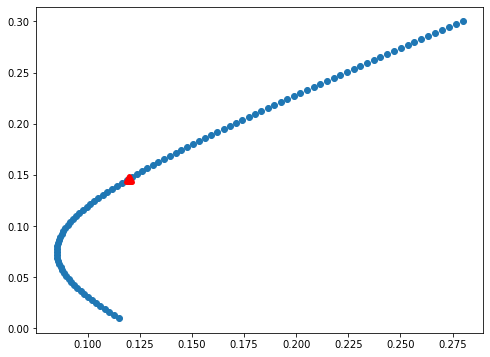

In [115]:
fig= plt.figure(figsize = (8,6))
plt.scatter(x=efport['targetvols'], y=efport['targetrets'])
plt.scatter(x=[tangency['vol']], y=[tangency['ret']],color = 'red',linewidths=5,marker = '^')
fig.show()

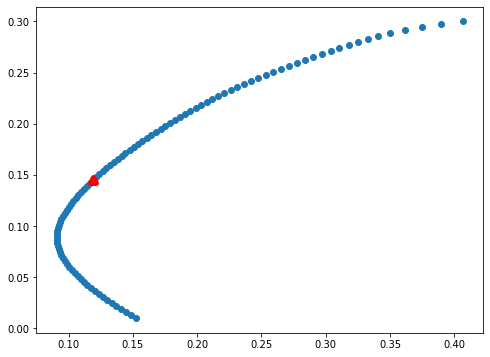

In [116]:
fig= plt.figure(figsize = (8,6))
plt.scatter(x=efport_noshort['targetvols'], y=efport_noshort['targetrets'])
plt.scatter(x=[tangency_noshort['vol']], y=[tangency_noshort['ret']],color = 'red',linewidths=5,marker = '^')
fig.show()

In [117]:
round(assetWeight.T,4)

,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
Weight,-0.0348,0.0234,0.0468,0.0664,0.0895,-0.0045,0.0289,-0.0035,0.1858,0.2703,0.0224,0.0141,0.0,0.0279,-0.0128,0.0101,0.0456,0.1262,0.0217,0.0765


In [118]:
round(assetWeight_noshort.T,4)

,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
Weight,0.0,0.0217,0.0388,0.0591,0.066,0.0,0.0234,0.0,0.1648,0.2628,0.0334,0.0136,0.0,0.0202,0.0,0.0096,0.06,0.1263,0.025,0.0751
